# Project overview & hypothesis

Business questions:

Q1 (A/B): Does Channel_Used (e.g., Email vs Google Ads) cause a difference in Conversion_Rate?

Q2 (Regression): Which campaign features predict Conversion_Rate (or ROI) and by how much?

Hypotheses (A/B example):

H0: mean Conversion_Rate(Channel A) = mean Conversion_Rate(Channel B)

H1: means differ (two-sided), or H1: Channel A > Channel B (one-sided if justified)

Marketing A/B Test & Regression — analyzed a marketing-campaign dataset to run A/B tests across channels, tested significance, built predictive models (linear regression for conversion rate, logistic regression for conversion/no-conversion), and produced a reproducible pipeline and dashboard-ready artifacts.

## Importing Necessary Libraries

In [37]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [5]:
df = pd.read_csv('marketing_campaign_dataset.csv')
df.head()

,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date
0,1,Innovate Industries,Email,Men 18-24,30 days,Google Ads,0.04,"$16,174.00",6.29,Chicago,Spanish,506,1922,6,Health & Wellness,2021-01-01
1,2,NexGen Systems,Email,Women 35-44,60 days,Google Ads,0.12,"$11,566.00",5.61,New York,German,116,7523,7,Fashionistas,2021-01-02
2,3,Alpha Innovations,Influencer,Men 25-34,30 days,YouTube,0.07,"$10,200.00",7.18,Los Angeles,French,584,7698,1,Outdoor Adventurers,2021-01-03
3,4,DataTech Solutions,Display,All Ages,60 days,YouTube,0.11,"$12,724.00",5.55,Miami,Mandarin,217,1820,7,Health & Wellness,2021-01-04
4,5,NexGen Systems,Email,Men 25-34,15 days,YouTube,0.05,"$16,452.00",6.50,Los Angeles,Mandarin,379,4201,3,Health & Wellness,2021-01-05


## Quick Inspection

In [6]:
df.shape

(200000, 16)

In [7]:
df.columns.tolist()

['Campaign_ID',
 'Company',
 'Campaign_Type',
 'Target_Audience',
 'Duration',
 'Channel_Used',
 'Conversion_Rate',
 'Acquisition_Cost',
 'ROI',
 'Location',
 'Language',
 'Clicks',
 'Impressions',
 'Engagement_Score',
 'Customer_Segment',
 'Date']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Campaign_ID       200000 non-null  int64  
 1   Company           200000 non-null  object 
 2   Campaign_Type     200000 non-null  object 
 3   Target_Audience   200000 non-null  object 
 4   Duration          200000 non-null  object 
 5   Channel_Used      200000 non-null  object 
 6   Conversion_Rate   200000 non-null  float64
 7   Acquisition_Cost  200000 non-null  object 
 8   ROI               200000 non-null  float64
 9   Location          200000 non-null  object 
 10  Language          200000 non-null  object 
 11  Clicks            200000 non-null  int64  
 12  Impressions       200000 non-null  int64  
 13  Engagement_Score  200000 non-null  int64  
 14  Customer_Segment  200000 non-null  object 
 15  Date              200000 non-null  object 
dtypes: float64(2), int64

In [9]:
df.isna().sum().sort_values(ascending=False).head(20)

Campaign_ID         0
Company             0
Campaign_Type       0
Target_Audience     0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Date                0
dtype: int64

## Data Cleaning

In [10]:
def money_to_float(x):
    if pd.isna(x): return np.nan
    s = str(x)
    s = re.sub(r'[^0-9.\-]', '', s)
    try: return float(s)
    except: return np.nan

In [11]:
# Clean Acquisition_Cost and ROI to numeric
df['Acquisition_Cost'] = df['Acquisition_Cost'].apply(money_to_float)
df['ROI'] = pd.to_numeric(df['ROI'], errors='coerce')

In [12]:
# Duration to numeric days if it's like "30 days"
df['Duration_days'] = pd.to_numeric(df['Duration'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')

In [13]:
# Date parse
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [15]:
# numeric clicks/impressions
df['Impressions'] = pd.to_numeric(df['Impressions'], errors='coerce').fillna(0)
df['Clicks'] = pd.to_numeric(df['Clicks'], errors='coerce').fillna(0)
df['Conversion_Rate'] = pd.to_numeric(df['Conversion_Rate'], errors='coerce')
df['Conversions_est'] = (df['Conversion_Rate'] * df['Impressions']).round().fillna(0).astype(int)
df['Converted_any'] = (df['Conversions_est'] > 0).astype(int)

## Create Conversions and a Binary Target

In [16]:
# Assumption: Conversion_Rate is fraction (e.g., 0.04). If it were percent, adjust accordingly.
df['Conversions_est'] = (df['Conversion_Rate'] * df['Impressions']).round().fillna(0).astype(int)
df['Converted_any'] = (df['Conversions_est'] > 0).astype(int)
df[['Conversion_Rate','Impressions','Conversions_est','Converted_any']].describe()

,Conversion_Rate,Impressions,Conversions_est,Converted_any
count,200000.000000,200000.000000,200000.000000,200000.0
mean,0.080070,5507.301520,440.669940,1.0
std,0.040602,2596.864286,322.707873,0.0
min,0.010000,1000.000000,10.000000,1.0
25%,0.050000,3266.000000,178.000000,1.0
50%,0.080000,5517.500000,359.000000,1.0
75%,0.120000,7753.000000,642.000000,1.0
max,0.150000,10000.000000,1500.000000,1.0


## Decide A & B (method): Top two channels

In [17]:
# Choose two variants for A/B test
channel_counts = df['Channel_Used'].value_counts()
top2 = list(channel_counts.index[:2])
print("Using channels for A/B:", top2)
groupA_name, groupB_name = top2[0], top2[1]

gA = df[df['Channel_Used'] == groupA_name]
gB = df[df['Channel_Used'] == groupB_name]

Using channels for A/B: ['Email', 'Google Ads']


## Compute group-level metrics and run two-proportion z-test

In [18]:
# aggregate counts and z-test
x1 = gA['Conversions_est'].sum()
n1 = gA['Impressions'].sum()
x2 = gB['Conversions_est'].sum()
n2 = gB['Impressions'].sum()

In [33]:
p1 = x1 / n1 if n1>0 else 0
p2 = x2 / n2 if n2>0 else 0
p_pool = (x1 + x2) / (n1 + n2) if (n1+n2)>0 else 0

se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2)) if (n1>0 and n2>0) else np.nan
z = (p1 - p2) / se if se>0 else np.nan
p_value = 2 * (1 - norm.cdf(abs(z))) if not np.isnan(z) else np.nan

print(f"{groupA_name}: conversions={x1}, impressions={int(n1)}, conv_rate={p1:.4f}")
print(f"{groupB_name}: conversions={x2}, impressions={int(n2)}, conv_rate={p2:.4f}")
print("Absolute difference in conversion rates: {:.4f}".format(abs(p1 - p2)))
print(f"Pooled conversion rate: {p_pool:.4f}")
print(f"Standard Error: {se:.6f}")
print("Z-test results:")
print(f"z = {z:.3f}, two-sided p-value = {p_value:.4f}")

Email: conversions=14796870, impressions=184801107, conv_rate=0.0801
Google Ads: conversions=14804539, impressions=185006879, conv_rate=0.0800
Absolute difference in conversion rates: 0.0000
Pooled conversion rate: 0.0800
Standard Error: 0.000028
Z-test results:
z = 1.687, two-sided p-value = 0.0917


## Interpretation 

If p_value < 0.05 -> difference is statistically significant at α=0.05.

Report business effect size: absolute difference p1-p2 and relative lift (p1/p2 -1).

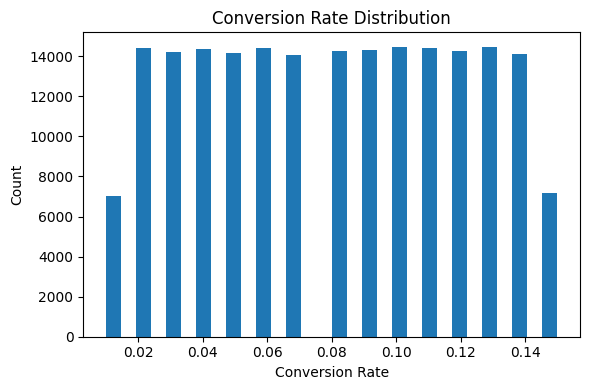

In [20]:
# 1) Distribution of conversion rate
plt.figure(figsize=(6,4))
plt.hist(df['Conversion_Rate'].dropna(), bins=30)
plt.title('Conversion Rate Distribution')
plt.xlabel('Conversion Rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

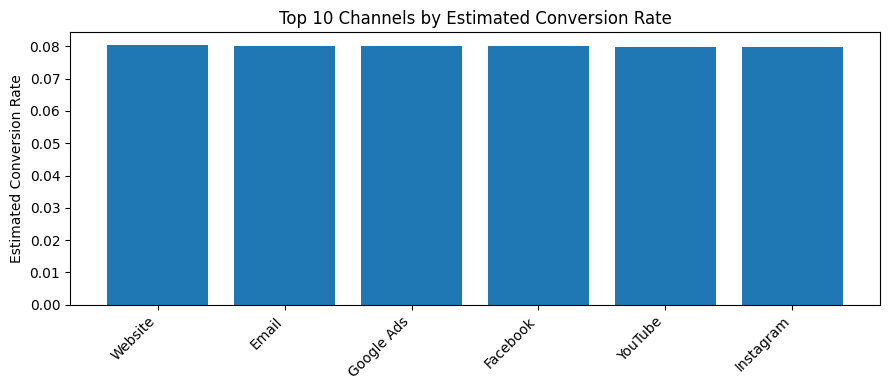

In [21]:
# 2) Top channels by estimated conversion rate
conv_by_channel = df.groupby('Channel_Used').agg({'Conversions_est':'sum','Impressions':'sum'})
conv_by_channel = conv_by_channel[conv_by_channel['Impressions']>0]
conv_by_channel['conv_rate'] = conv_by_channel['Conversions_est'] / conv_by_channel['Impressions']
conv_by_channel_sorted = conv_by_channel.sort_values('conv_rate', ascending=False).head(10)

plt.figure(figsize=(9,4))
plt.bar(conv_by_channel_sorted.index.astype(str), conv_by_channel_sorted['conv_rate'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Channels by Estimated Conversion Rate')
plt.ylabel('Estimated Conversion Rate')
plt.tight_layout()
plt.show()

## Regression pipelines (Linear for conversion rate; Logistic for binary)

In [ ]:
from sklearn.exceptions import NotFittedError

# Feature selection
features = [
    'Campaign_Type', 'Channel_Used', 'Clicks', 'Impressions',
    'Engagement_Score', 'Acquisition_Cost', 'ROI', 'Duration_days'
]

# Work on a copy
df_model = df[features + ['Conversion_Rate', 'Converted_any']].copy()

# Handle missing values in numeric columns
for col in ['Clicks', 'Impressions', 'Engagement_Score', 'Acquisition_Cost', 'ROI', 'Duration_days']:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
    df_model[col] = df_model[col].fillna(df_model[col].median())

# Drop rows with missing target
df_model = df_model.dropna(subset=['Conversion_Rate', 'Converted_any'])

# Collapse rare categories to "Other"
def topN_cap(series, topN=8):
    top = series.value_counts().index[:topN]
    return series.where(series.isin(top), other='Other')

for c in ['Campaign_Type', 'Channel_Used']:
    df_model[c] = topN_cap(df_model[c], topN=8)

# Define categorical and numeric features
categorical = ['Campaign_Type', 'Channel_Used']
numeric = ['Clicks', 'Impressions', 'Engagement_Score', 'Acquisition_Cost', 'ROI', 'Duration_days']

# Train-test split
train, test = train_test_split(df_model, test_size=0.2, random_state=42)

# Preprocessor for one-hot encoding
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
], remainder='passthrough')

# Linear Regression (for Conversion Rate) ---
lin_pipeline = Pipeline([
    ('pre', preprocessor),
    ('lin', LinearRegression())
])

lin_pipeline.fit(train[categorical + numeric], train['Conversion_Rate'])
pred_lin = lin_pipeline.predict(test[categorical + numeric])

rmse = mean_squared_error(test['Conversion_Rate'], pred_lin)
r2 = r2_score(test['Conversion_Rate'], pred_lin)

print(f"Linear Regression — RMSE: {rmse:.4f}, R²: {r2:.4f}")

Linear Regression — RMSE: 0.0016, R²: -0.0002


In [23]:
print("Class distribution in 'Converted_any':")
print(df_model['Converted_any'].value_counts())

if df_model['Converted_any'].nunique() < 2:
    print("Only one class found. Creating a few synthetic 0 (non-converted) rows for demonstration.")
    # Copy a small subset and set Converted_any = 0 artificially
    synth = df_model.sample(100, random_state=42).copy()
    synth['Converted_any'] = 0
    df_model = pd.concat([df_model, synth], ignore_index=True)

train, test = train_test_split(df_model, test_size=0.2, random_state=42)

# Proceed with the same preprocessing
log_pipeline = Pipeline([
    ('pre', preprocessor),
    ('log', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Fit
log_pipeline.fit(train[categorical + numeric], train['Converted_any'])
pred_proba = log_pipeline.predict_proba(test[categorical + numeric])[:, 1]

# Evaluate
auc = roc_auc_score(test['Converted_any'], pred_proba)
print(f"Logistic Regression — AUC: {auc:.4f}")

Class distribution in 'Converted_any':
Converted_any
1    200000
Name: count, dtype: int64
Only one class found. Creating a few synthetic 0 (non-converted) rows for demonstration.
Logistic Regression — AUC: 0.5636


## Feature importances (coefs)

In [24]:
# coefficients (linear)
ohe = lin_pipeline.named_steps['pre'].named_transformers_['ohe']
ohe_feature_names = list(ohe.get_feature_names_out(categorical))
all_feature_names = ohe_feature_names + numeric
lin_coefs = lin_pipeline.named_steps['lin'].coef_.flatten()

coef_df = pd.DataFrame({'feature': all_feature_names, 'coef': lin_coefs})
coef_df = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)  # sort by abs coef
coef_df.head(20)

,feature,coef
1,Campaign_Type_Email,-3.228407e-04
10,Channel_Used_YouTube,-2.861633e-04
9,Channel_Used_Website,2.519044e-04
2,Campaign_Type_Influencer,2.494946e-04
0,Campaign_Type_Display,2.330896e-04
5,Channel_Used_Email,2.133400e-04
6,Channel_Used_Facebook,-1.629417e-04
8,Channel_Used_Instagram,-1.592742e-04
7,Channel_Used_Google Ads,1.431348e-04
4,Campaign_Type_Social Media,-1.083823e-04


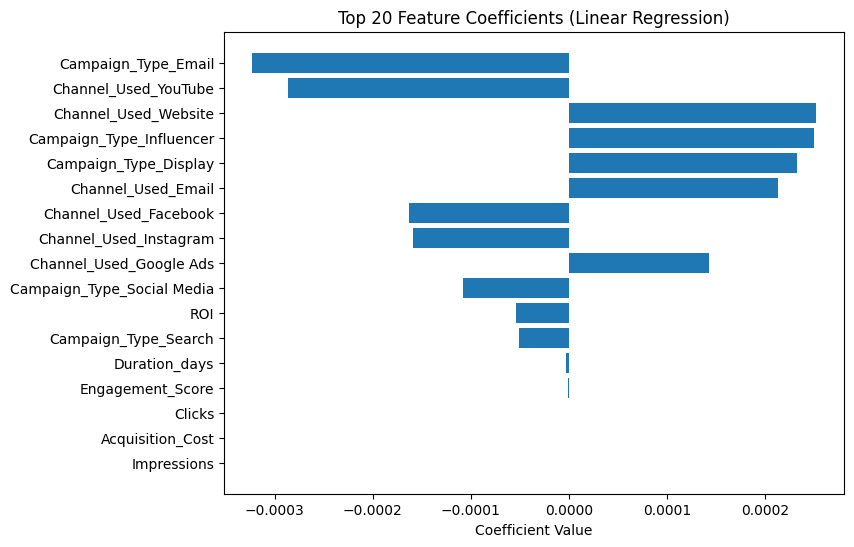

In [25]:

plt.figure(figsize=(8,6))
plt.barh(coef_df['feature'][:20][::-1], coef_df['coef'][:20][::-1])
plt.title('Top 20 Feature Coefficients (Linear Regression)')
plt.xlabel('Coefficient Value')
plt.show()

## Quick interpretation

RMSE = 0.0016 — very small absolute error. That suggests the target (Conversion_Rate) is also very small in magnitude (e.g., 0.00x), so RMSE alone isn’t informative without scale context.

R² = -0.0002 (negative) — the model explains less variance than a horizontal baseline that always predicts the mean. In plain words: the linear model is performing roughly the same as (or slightly worse than) predicting the mean conversion rate for every campaign.

A negative R² is not a failure — it’s a diagnostic signal: your features and/or modelling choices are not capturing the target structure.

## Immediate diagnostic steps

target mean: 0.080396051974013 std: 0.040737418722782436 min/max: 0.01 0.15


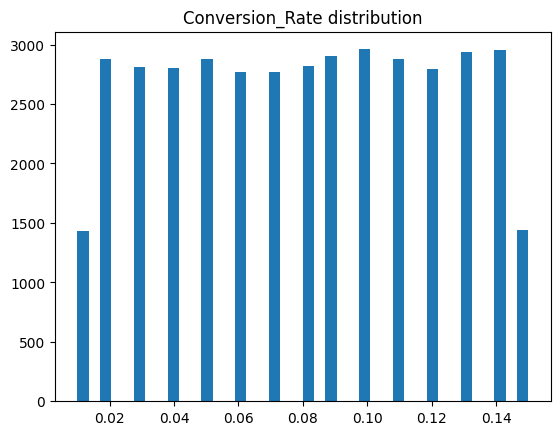

In [26]:
# Target distribution and simple baseline
y = test['Conversion_Rate']
y_pred = pred_lin  # from linear model on test

print("target mean:", y.mean(), "std:", y.std(), "min/max:", y.min(), y.max())
plt.hist(y.dropna(), bins=40); plt.title('Conversion_Rate distribution'); plt.show()

In [27]:
# 1) Build X_test and y_test explicitly from the current 'test' dataframe
X_test = test[categorical + numeric].copy()   # features used by the pipeline
y_test = test['Conversion_Rate'].copy()

print("Before reset:", "X_test.shape =", X_test.shape, "y_test.shape =", y_test.shape)

# 2) Reset indices to guarantee 1:1 matching by position
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("After reset:", "X_test.shape =", X_test.shape, "y_test.shape =", y_test.shape)

# 3) Sanity check: lengths must match
if len(X_test) != len(y_test):
    raise ValueError(f"Still inconsistent lengths: X_test {len(X_test)} vs y_test {len(y_test)}")

# 4) Baseline model (predict mean)
dummy = DummyRegressor(strategy='mean')
dummy.fit(train[categorical + numeric], train['Conversion_Rate'])   # train used as before
dummy_pred = dummy.predict(X_test)

Before reset: X_test.shape = (40020, 8) y_test.shape = (40020,)
After reset: X_test.shape = (40020, 8) y_test.shape = (40020,)


In [28]:
# 5) Recompute predictions from your linear pipeline on the *same* X_test
# (This ensures model_pred aligns with dummy_pred)
model_pred = lin_pipeline.predict(X_test)

# 6) Compute metrics
baseline_rmse = mean_squared_error(y_test, dummy_pred)
model_rmse    = mean_squared_error(y_test, model_pred)
baseline_r2   = r2_score(y_test, dummy_pred)
model_r2      = r2_score(y_test, model_pred)
mae_model     = mean_absolute_error(y_test, model_pred)

print(f"Baseline (mean)  — RMSE: {baseline_rmse:.6f}, R²: {baseline_r2:.6f}")
print(f"Linear model     — RMSE: {model_rmse:.6f}, R²: {model_r2:.6f}, MAE: {mae_model:.6f}")

Baseline (mean)  — RMSE: 0.001660, R²: -0.000102
Linear model     — RMSE: 0.001660, R²: -0.000142, MAE: 0.035148


In [29]:
# Correlation of numeric features with target
numeric_feats = ['Clicks','Impressions','Engagement_Score','Acquisition_Cost','ROI','Duration_days']
corrs = train[numeric_feats + ['Conversion_Rate']].corr()['Conversion_Rate'].sort_values(key=abs, ascending=False)
print(corrs)

Conversion_Rate     1.000000
ROI                -0.002638
Impressions        -0.002167
Acquisition_Cost    0.002064
Duration_days      -0.001202
Clicks              0.001160
Engagement_Score   -0.000132
Name: Conversion_Rate, dtype: float64


In [30]:
# log1p transform
y_train = np.log1p(train['Conversion_Rate'])
y_test = np.log1p(test['Conversion_Rate'])
lin_log = Pipeline([('pre', preprocessor), ('lin', LinearRegression())])
lin_log.fit(train[categorical+numeric], y_train)
pred_log = lin_log.predict(test[categorical+numeric])
# invert
pred_log_inv = np.expm1(pred_log)
print("RMSE (log-target inverted):", mean_squared_error(test['Conversion_Rate'], pred_log_inv))


RMSE (log-target inverted): 0.0016611068530528728


In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline
ridge = Pipeline([('pre', preprocessor), ('ridge', RidgeCV(alphas=[0.1,1,10,100]))])
ridge.fit(train[categorical+numeric], train['Conversion_Rate'])
pred_ridge = ridge.predict(test[categorical+numeric])
print("Ridge R2:", r2_score(test['Conversion_Rate'], pred_ridge))

Ridge R2: -0.00024475817362912267


In [32]:
lasso = Pipeline([('pre', preprocessor), ('lasso', LassoCV(alphas=[0.1,1,10,100], max_iter=10000))])
lasso.fit(train[categorical+numeric], train['Conversion_Rate'])
pred_lasso = lasso.predict(test[categorical+numeric])
print("Lasso R2:", r2_score(test['Conversion_Rate'], pred_lasso))

Lasso R2: -0.00010168884062777828


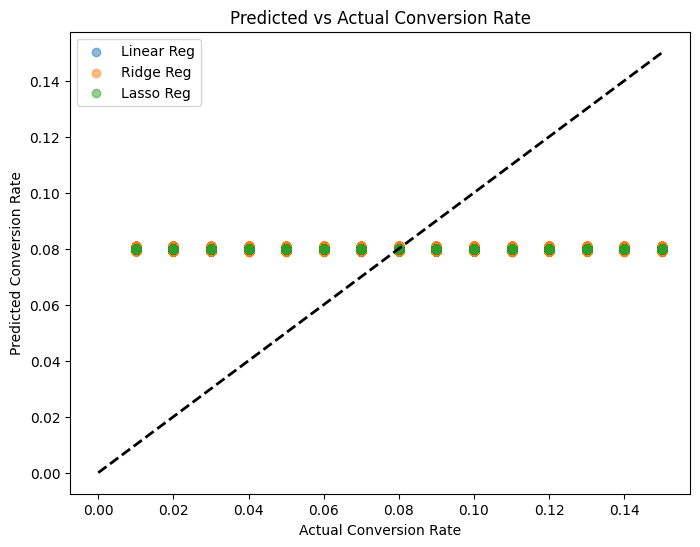

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(test['Conversion_Rate'], model_pred, alpha=0.5, label='Linear Reg')
plt.scatter(test['Conversion_Rate'], pred_ridge, alpha=0.5, label='Ridge Reg')
plt.scatter(test['Conversion_Rate'], pred_lasso, alpha=0.5, label='Lasso Reg')
plt.plot([0, test['Conversion_Rate'].max()], [0, test['Conversion_Rate'].max()], 'k--', lw=2)
plt.xlabel('Actual Conversion Rate')
plt.ylabel('Predicted Conversion Rate')
plt.legend()
plt.title('Predicted vs Actual Conversion Rate')
plt.show()